In [55]:
# tools 
import os 

# custom 
from toy_gaussian_splatting.gaussian_2D_render import surface_splatting
from toy_gaussian_splatting.gaussian_3D_render import volume_splatting
from toy_utils.utils import toy_gaussian_model, focal2fov, getProjectionMatrix
from munch import munchify

# math 
import torch 
import numpy as np 

# visualization 
import matplotlib.pyplot as plt 
import matplotlib

DEVICE = 'cpu'


In [2]:
def get_viewmat():
    c2w = torch.tensor([[-8.6086e-01,  3.7950e-01, -3.3896e-01,  6.7791e-01],
         [ 5.0884e-01,  6.4205e-01, -5.7346e-01,  1.1469e+00],
         [ 1.0934e-08, -6.6614e-01, -7.4583e-01,  1.4917e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]).to(DEVICE)

    viewmat = torch.linalg.inv(c2w).permute(1,0)
    return {"viewmat" : viewmat, "R" : viewmat[:3, :3], "T" : viewmat[-1:, :3]}


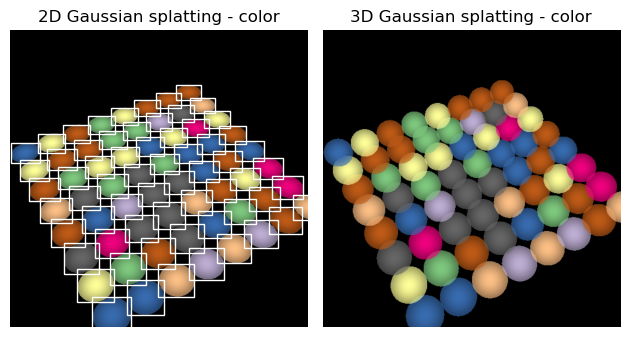

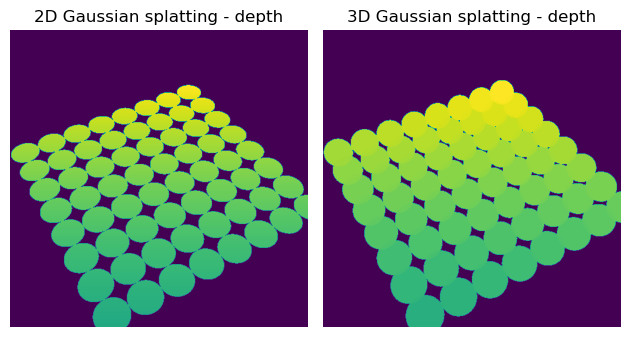

In [4]:
# Make inputs
num_points1 = 8
gaussians = munchify(toy_gaussian_model(num_points=num_points1))
viewmat   = munchify(get_viewmat())

render2D = surface_splatting(
    gaussians.means3D, gaussians.scales, gaussians.quats, viewmat, gaussians.projmat, 
    gaussians.colors, gaussians.opacities, gaussians.intrins, device='cpu', 
)
render3D = volume_splatting(
    gaussians.means3D, gaussians.scales, gaussians.quats, viewmat, gaussians.projmat, 
    gaussians.colors, gaussians.opacities, gaussians.intrins, DEVICE='cpu'
)

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = render2D["center"].cpu().detach().numpy()
half_extend = render2D["radii"].cpu().numpy() * 1/3 # only show one sigma
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()
# visualize AABB
for k in range(len(half_extend)):
    ax1.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))
    # ax3.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))

img1 = render2D["render"].permute(1, 2, 0).cpu().numpy()
img2 = render3D["render"].permute(1, 2, 0).cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = render2D["depth"].cpu().squeeze().numpy()
img2 = render3D["depth"].cpu().squeeze().numpy()

ax3.imshow(img1)
ax4.imshow(img2)


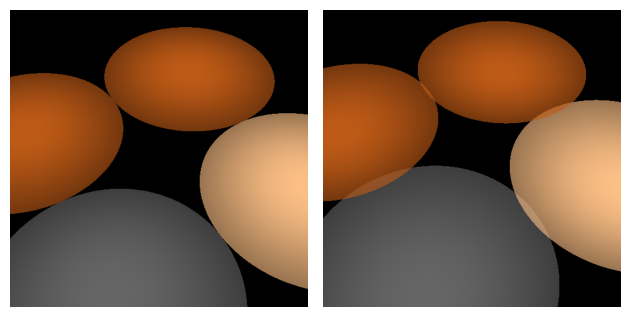

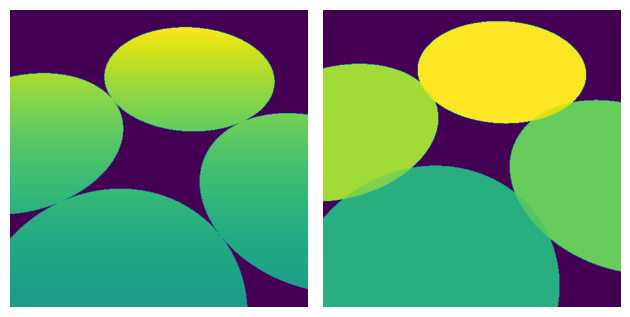

In [5]:
# reduce num of points to give a close look
num_points2=2
gaussians2 = munchify(toy_gaussian_model(num_points=num_points2))
gaussians2.scales[:,-1] = 0e-6
gaussians2.colors = torch.cat([gaussians.colors[:num_points2, :], gaussians.colors[num_points1:num_points1+num_points2, :]], dim=0)

# gaussians2.opacities = torch.ones_like(means3D[:,:1])

render2D = surface_splatting(
    gaussians2.means3D, gaussians2.scales, gaussians2.quats, viewmat, gaussians2.projmat, 
    gaussians2.colors, gaussians2.opacities, gaussians2.intrins, device='cpu', 
)
render3D = volume_splatting(
    gaussians2.means3D, gaussians2.scales, gaussians2.quats, viewmat, gaussians2.projmat, 
    gaussians2.colors, gaussians2.opacities, gaussians2.intrins, DEVICE='cpu'
)

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = render2D["center"].cpu().detach().numpy()
half_extend = render2D["radii"].cpu().numpy()
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
# ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
# ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

# ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
# ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()

img1 = render2D["render"].permute(1, 2, 0).cpu().numpy()
img2 = render3D["render"].permute(1, 2, 0).cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = render2D["depth"].squeeze().cpu().numpy()
img2 = render3D["depth"].squeeze().cpu().numpy()

ax3.imshow(img1)
ax4.imshow(img2)


---

In [1]:
from toy_utils.utils_cameras import generate_circular_trajectory
import numpy as np 

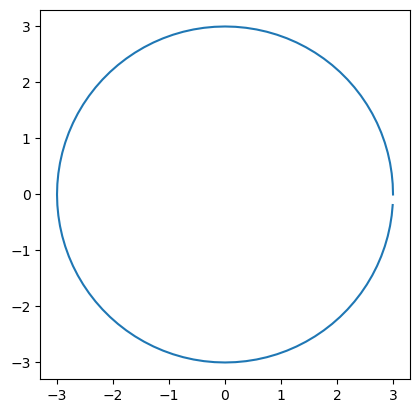

In [2]:
import matplotlib.pyplot as plt 

center = np.array([0, 0, 0])
radius = 3
num_steps = 100
cameras_circle = generate_circular_trajectory(center, radius, num_steps)

trajectory_circle = np.array([cameras_circle[j][:3, 3] for j in range(num_steps)])
fig, axe = plt.subplots()
axe.plot(trajectory_circle[:, 0], trajectory_circle[:, 2])
axe.set_aspect('equal')
plt.show()

In [3]:
from utils.pose_utils import SE3_exp
from munch import munchify
from toy_utils.utils import toy_gaussian_model
import torch 
from toy_gaussian_splatting.gaussian_2D_render import surface_splatting

num_points = 8
gaussians  = munchify(toy_gaussian_model(num_points=num_points))
cameras    = [cameras_circle[10], cameras_circle[30]]
renders    = []

for c2w in cameras:
    viewmat = torch.linalg.inv(c2w)#.permute(1, 0)
    viewpoint = munchify(
        {"R" : viewmat[:3, :3], "T" : viewmat[:3, 3], "cam_trans_delta" : torch.zeros(3), "cam_rot_delta" : torch.zeros(3)}
    )
    # tau = torch.cat([viewpoint.cam_trans_delta, viewpoint.cam_rot_delta], axis=0)
    # viewmat = torch.eye(4, device=tau.device)
    # viewmat[0:3, 0:3] = viewpoint.R
    # viewmat[0:3, 3] = viewpoint.T
    # viewmat = SE3_exp(tau) @ viewmat

    # print(viewmat)

    render2D = surface_splatting(
    gaussians.means3D, gaussians.scales, gaussians.quats, viewpoint, gaussians.projmat, 
    gaussians.colors, gaussians.opacities, gaussians.intrins, device='cpu', 
    )   
    renders.append(render2D)

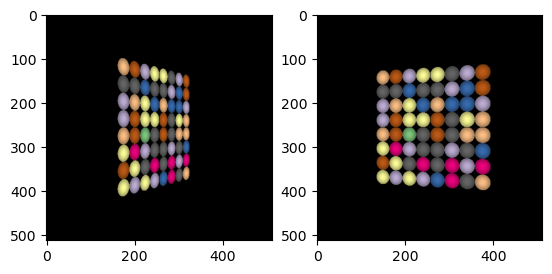

In [4]:
plt.subplot(121); plt.imshow(renders[0]["render"].permute(1, 2, 0).numpy())
plt.subplot(122); plt.imshow(renders[1]["render"].permute(1, 2, 0).numpy())
plt.show()

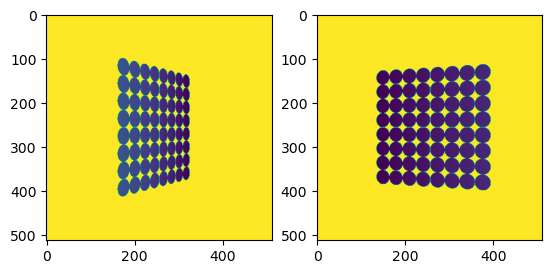

In [10]:
plt.subplot(121); plt.imshow(renders[0]['depth'].numpy(), cmap='viridis')
plt.subplot(122); plt.imshow(renders[1]['depth'].numpy(), cmap='viridis')
plt.show()

In [11]:
# build map of normals 
from toy_utils.utils import build_rotation
from toy_utils.utils import homogeneous

ax_disk = build_rotation(gaussians.quats)
normals = ax_disk[:, :, 2]
viewmat = torch.linalg.inv(cameras[0])
normals_transf = (((viewmat.T @ homogeneous(normals).T).T)[:, :3] + 1)/2

pix = torch.stack(torch.meshgrid(torch.arange(512), torch.arange(512), indexing='xy'), dim=-1)
x   = pix.reshape(-1,1,2)[..., :1]
y   = pix.reshape(-1,1,2)[..., 1:]
pixels = torch.cat([x,y], dim=-1)

point_image = renders[0]["center"]
half_extend = renders[0]["radii"] * 1/3 # only show one sigma


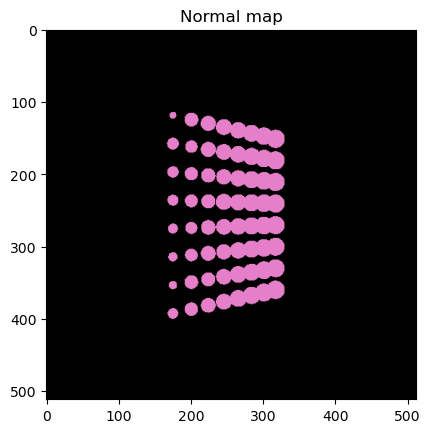

In [12]:
normal_map    = torch.zeros(512, 512, 3)
num_gaussians = 8*8
for i in range(num_gaussians):
    mask = ((pixels - point_image[None,i,:2]).norm(dim=-1)**2 < half_extend[i:, :2].norm()).view(512, 512)
    normal_map[mask] = normals_transf[i]

plt.imshow(normal_map)
plt.title("Normal map")
plt.show()

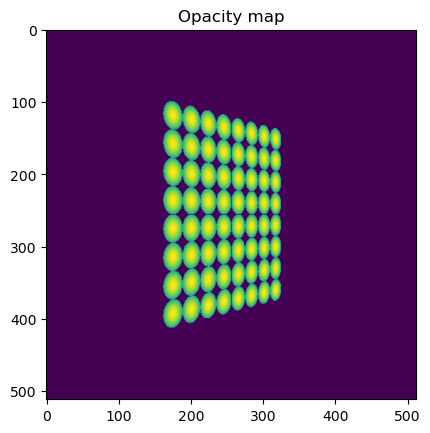

In [13]:
plt.imshow(renders[0]["opacity"].squeeze())
plt.title("Opacity map")
plt.show()

-----------------------

In [14]:
import torch 
from utils.config_utils import load_config
from utils.slam_utils import image_gradient, image_gradient_mask

def compute_grad_mask(config, image):
    edge_threshold = config["Training"]["edge_threshold"]

    gray_img = image.mean(dim=0, keepdim=True).to(torch.float32)
    gray_grad_v, gray_grad_h = image_gradient(gray_img)
    mask_v, mask_h = image_gradient_mask(gray_img)
    gray_grad_v = gray_grad_v * mask_v
    gray_grad_h = gray_grad_h * mask_h
    img_grad_intensity = torch.sqrt(gray_grad_v**2 + gray_grad_h**2)

    median_img_grad_intensity = img_grad_intensity.median()
    grad_mask = (
                img_grad_intensity > median_img_grad_intensity * edge_threshold
            )
    return grad_mask

def get_loss_tracking_rgb(config, image, depth, opacity, viewpoint):
    gt_image = viewpoint.original_image#.cuda()
    _, h, w = gt_image.shape
    mask_shape = (1, h, w)
    rgb_boundary_threshold = config["Training"]["rgb_boundary_threshold"]
    rgb_pixel_mask = (gt_image.sum(dim=0) > rgb_boundary_threshold).view(*mask_shape)
    rgb_pixel_mask = rgb_pixel_mask * viewpoint.grad_mask
    # print(opacity.shape, image.shape, rgb_pixel_mask.shape, gt_image.shape)
    l1 = opacity * torch.abs(image * rgb_pixel_mask - gt_image * rgb_pixel_mask)
    return l1.mean()

config = load_config("./configs/mono/tum/toy_config.yml")

image     = renders[0]["render"]
grad_mask = compute_grad_mask(config, image)
viewmat   = torch.linalg.inv(cameras[0]).permute(1, 0)
viewmat   = munchify(
    {"R" : viewmat[:3, :3], "T" : viewmat[-1:, :3], "original_image" : image, "grad_mask" : grad_mask}
)

get_loss_tracking_rgb(config, image=image, depth=None, opacity=renders[0]["opacity"].permute(2, 0, 1), viewpoint=viewmat)

tensor(0., dtype=torch.float64)

In [15]:
def get_median_depth(depth, opacity=None, mask=None, return_std=False):
    depth = depth.detach().clone()
    opacity = opacity.detach()
    valid = depth > 0
    # print(valid.shape, (opacity > 0.95).shape)
    if opacity is not None:
        valid = torch.logical_and(valid, opacity > 0.95)
    if mask is not None:
        valid = torch.logical_and(valid, mask)
    valid_depth = depth[valid]
    if return_std:
        return valid_depth.median(), valid_depth.std(), valid
    return valid_depth.median()

median_depth = get_median_depth(renders[0]["depth"], renders[0]["opacity"])

---

### Test tracking 

In [44]:
from utils.config_utils import load_config
from utils.dataset import load_dataset
from munch import munchify
import torch 
import matplotlib.pyplot as plt 

config       = load_config('./configs/mono/tum/toy_config.yml')
model_params = munchify(config["model_params"])
dataset      = load_dataset(
    model_params, model_params.source_path, config=config
)

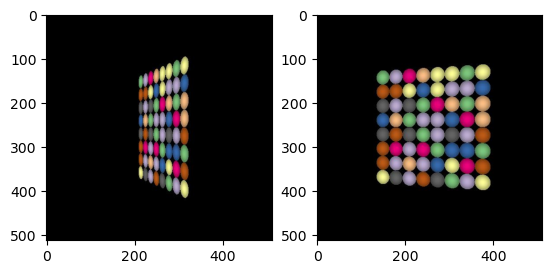

In [45]:
idx1, idx2 = 20, 60
image1, depth1, pose1 = dataset[idx1]
image2, depth2, pose2 = dataset[idx2]
plt.subplot(121); plt.imshow(image1.permute(1, 2, 0)); 
plt.subplot(122); plt.imshow(image2.permute(1, 2, 0))

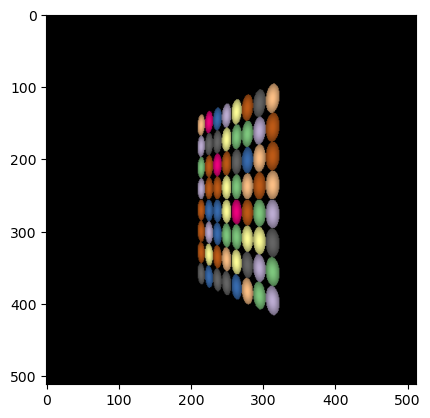

0.015065507972638914


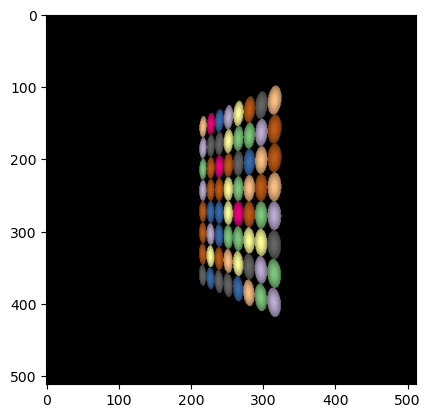

0.014649943355556208


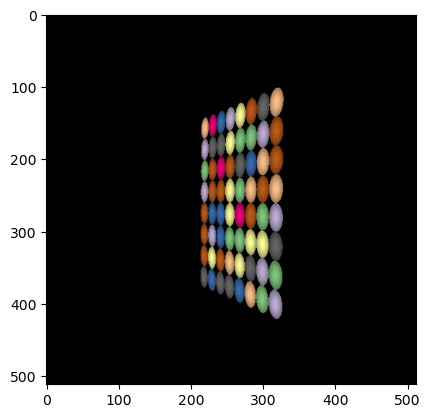

0.013960086803669012


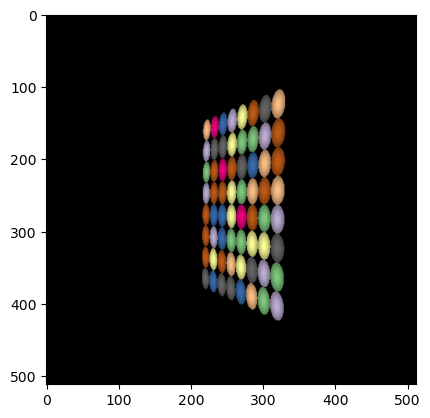

0.013226914256051978


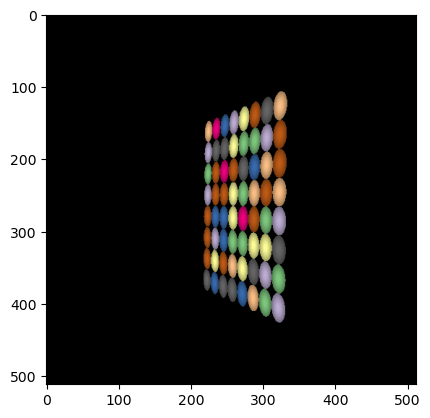

0.012761991029783246


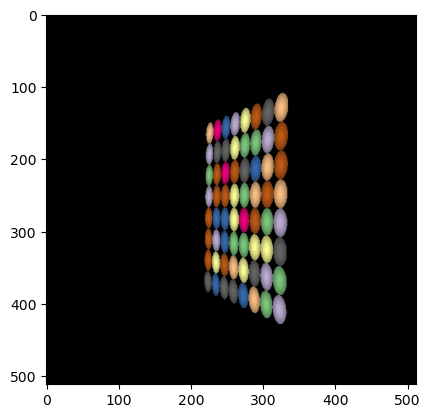

0.012595728934054412


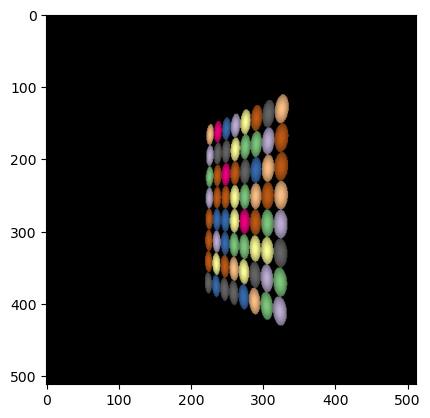

0.012416350169114555


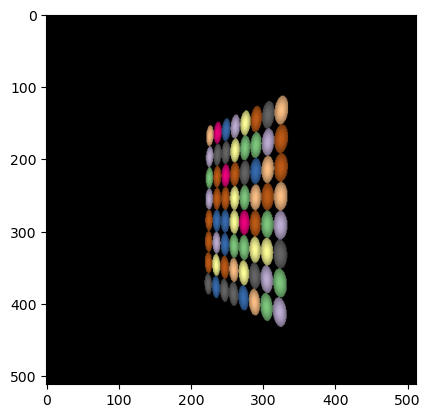

0.012209783887622769


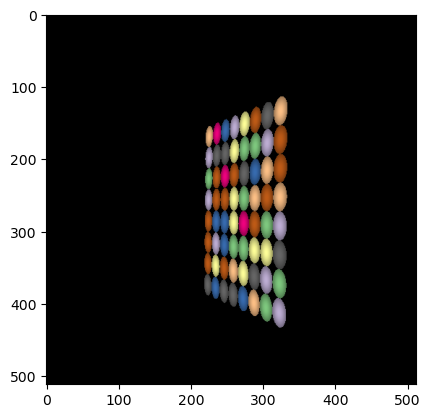

0.011991467050343409


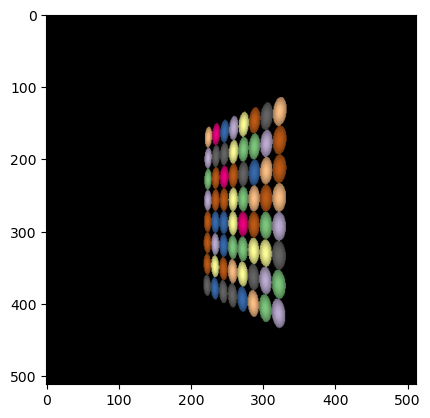

0.01183517594489103


In [46]:
from toy_utils.utils import toy_gaussian_model
from munch import munchify
from utils.camera_utils import Camera
from gaussian_splatting.utils.graphics_utils import getProjectionMatrix2
from utils.slam_utils import get_loss_tracking
from utils.pose_utils import update_pose
from toy_gaussian_splatting.gaussian_2D_render import surface_splatting

projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)

gaussians = munchify(toy_gaussian_model(num_points=8))
viewpoint1 = Camera.init_from_dataset(dataset, idx1, projection_matrix=projection_matrix)
viewpoint2 = Camera.init_from_dataset(dataset, idx2, projection_matrix=projection_matrix)

prev = viewpoint1
viewpoint2.update_RT(prev.R_gt, prev.T_gt)
viewpoint2.compute_grad_mask(config)

opt_params = []
opt_params.append(
            {
                "params": [viewpoint2.cam_rot_delta],
                "lr": config["Training"]["lr"]["cam_rot_delta"],
                "name": "rot_{}".format(viewpoint2.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint2.cam_trans_delta],
                "lr": config["Training"]["lr"]["cam_trans_delta"],
                "name": "trans_{}".format(viewpoint2.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint2.exposure_a],
                "lr": 0.01,
                "name": "exposure_a_{}".format(viewpoint2.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint2.exposure_b],
                "lr": 0.01,
                "name": "exposure_b_{}".format(viewpoint2.uid),
            }
        )

pose_optimizer = torch.optim.Adam(opt_params)

tracking_itr_num = 10
for tracking_itr in range(tracking_itr_num):
    
    render_2D = surface_splatting(
        gaussians.means3D, gaussians.scales, 
        gaussians.quats, viewpoint2, 
        gaussians.projmat, gaussians.colors, 
        gaussians.opacities, gaussians.intrins, 
        device="cpu"
    )
    image, depth, opacity = (
        render_2D["render"], 
        render_2D["depth"], 
        render_2D["opacity"]
    )
    plt.imshow(image.detach().permute(1,2,0))
    plt.show()
    pose_optimizer.zero_grad()
    loss_tracking = get_loss_tracking(
            config, image, depth, opacity.permute(2, 0, 1), viewpoint2
    )
    print(loss_tracking.item())
    # print('image.requires_grad:', image.requires_grad)
    # print("loss_tracking.requires_grad:", loss_tracking.requires_grad)
    loss_tracking.backward()
      
    with torch.no_grad():
        pose_optimizer.step()
        # Debug: Print updated parameters
        # print("After step - cam_rot_delta:", viewpoint2.cam_rot_delta)
        # print("After step - cam_trans_delta:", viewpoint2.cam_trans_delta)
        converged = update_pose(viewpoint2)

    # print("cam_rot_delta.grad:", viewpoint2.cam_rot_delta.grad)
    # print("cam_trans_delta.grad:", viewpoint2.cam_trans_delta.grad)



In [42]:
viewpoint1 = Camera.init_from_dataset(dataset, idx1, projection_matrix=projection_matrix)
viewpoint1.update_RT(viewpoint1.R_gt, viewpoint1.T_gt)

render_2D = surface_splatting(
        gaussians.means3D, gaussians.scales, 
        gaussians.quats, viewpoint1, 
        gaussians.projmat, gaussians.colors, 
        gaussians.opacities, gaussians.intrins, 
        device="cpu"
    )

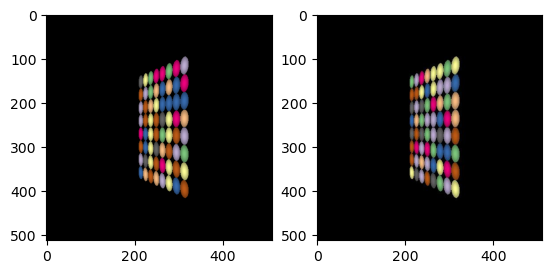

In [43]:
img1, _, _ = dataset[idx1]
plt.subplot(121); plt.imshow(render_2D['render'].detach().permute(1, 2, 0))
plt.subplot(122); plt.imshow(img1.permute(1, 2, 0))